# Heston Stochastic Volatility Model

## Introduction

The **Heston model** (1993) is a mathematical model describing the evolution of asset prices where volatility itself follows a stochastic process. Unlike the Black-Scholes model which assumes constant volatility, the Heston model captures important market phenomena such as:

- **Volatility clustering**: Periods of high volatility tend to cluster together
- **Mean reversion**: Volatility tends to return to a long-term average
- **Leverage effect**: Negative correlation between asset returns and volatility
- **Volatility smile**: The observed pattern of implied volatilities across strike prices

## Mathematical Framework

### The Heston Model Dynamics

The Heston model is defined by the following system of stochastic differential equations (SDEs):

$$dS_t = \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S$$

$$dv_t = \kappa(\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v$$

where:
- $S_t$ is the asset price at time $t$
- $v_t$ is the instantaneous variance at time $t$
- $\mu$ is the drift rate of the asset
- $\kappa$ is the rate of mean reversion of variance
- $\theta$ is the long-term variance (mean level)
- $\sigma$ is the volatility of volatility (vol-of-vol)
- $W_t^S$ and $W_t^v$ are correlated Wiener processes with $dW_t^S \cdot dW_t^v = \rho \, dt$

### Correlation Structure

The correlation parameter $\rho \in [-1, 1]$ captures the **leverage effect**:
- $\rho < 0$: Negative correlation (typical in equity markets) - when prices fall, volatility rises
- $\rho > 0$: Positive correlation - when prices rise, volatility rises

### Feller Condition

To ensure the variance process $v_t$ remains strictly positive, the **Feller condition** must be satisfied:

$$2\kappa\theta > \sigma^2$$

This condition ensures the mean-reverting drift dominates the stochastic component near zero.

### Variance Process: Cox-Ingersoll-Ross (CIR)

The variance process in the Heston model follows a **CIR process**, which has several desirable properties:
- Mean-reverting to $\theta$
- Non-negative (when Feller condition holds)
- Has a known stationary distribution (Gamma distribution)

The stationary distribution of $v_t$ is:

$$v_\infty \sim \text{Gamma}\left(\frac{2\kappa\theta}{\sigma^2}, \frac{\sigma^2}{2\kappa}\right)$$

## Numerical Simulation

### Discretization Schemes

We implement the **Euler-Maruyama** discretization scheme with **full truncation** to handle potential negative variance values:

$$S_{t+\Delta t} = S_t \exp\left[\left(\mu - \frac{v_t^+}{2}\right)\Delta t + \sqrt{v_t^+ \Delta t} \, Z_1\right]$$

$$v_{t+\Delta t} = v_t + \kappa(\theta - v_t^+)\Delta t + \sigma\sqrt{v_t^+ \Delta t} \, Z_2$$

where $v_t^+ = \max(v_t, 0)$ and $Z_1, Z_2$ are correlated standard normal random variables:

$$Z_1 = \epsilon_1, \quad Z_2 = \rho \epsilon_1 + \sqrt{1-\rho^2} \epsilon_2$$

with $\epsilon_1, \epsilon_2 \sim \mathcal{N}(0, 1)$ independent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Heston Model Parameters
S0 = 100.0      # Initial stock price
v0 = 0.04       # Initial variance (volatility = 20%)
mu = 0.05       # Drift rate (risk-free rate for risk-neutral)
kappa = 2.0     # Mean reversion speed
theta = 0.04    # Long-term variance
sigma = 0.3     # Volatility of volatility
rho = -0.7      # Correlation (leverage effect)
T = 1.0         # Time horizon (1 year)
N = 252         # Number of time steps (daily)
n_paths = 10000 # Number of Monte Carlo paths

# Check Feller condition
feller = 2 * kappa * theta / sigma**2
print(f"Feller ratio: {feller:.4f}")
print(f"Feller condition satisfied: {feller > 1}")

Feller ratio: 1.7778
Feller condition satisfied: True


In [2]:
def simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, n_paths):
    """
    Simulate asset price paths using the Heston stochastic volatility model.
    
    Uses Euler-Maruyama discretization with full truncation scheme.
    
    Parameters:
    -----------
    S0 : float - Initial stock price
    v0 : float - Initial variance
    mu : float - Drift rate
    kappa : float - Mean reversion speed
    theta : float - Long-term variance
    sigma : float - Volatility of volatility
    rho : float - Correlation between price and variance
    T : float - Time horizon
    N : int - Number of time steps
    n_paths : int - Number of simulation paths
    
    Returns:
    --------
    t : array - Time points
    S : array - Simulated stock prices (n_paths x N+1)
    v : array - Simulated variance paths (n_paths x N+1)
    """
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    
    # Initialize arrays
    S = np.zeros((n_paths, N + 1))
    v = np.zeros((n_paths, N + 1))
    S[:, 0] = S0
    v[:, 0] = v0
    
    # Generate correlated random numbers
    for i in range(N):
        # Independent standard normals
        Z1 = np.random.standard_normal(n_paths)
        Z2 = np.random.standard_normal(n_paths)
        
        # Correlated normals for variance process
        Zv = rho * Z1 + np.sqrt(1 - rho**2) * Z2
        
        # Full truncation scheme
        v_pos = np.maximum(v[:, i], 0)
        sqrt_v = np.sqrt(v_pos)
        
        # Update variance (CIR process)
        v[:, i+1] = v[:, i] + kappa * (theta - v_pos) * dt + sigma * sqrt_v * sqrt_dt * Zv
        
        # Update stock price (log-normal with stochastic volatility)
        S[:, i+1] = S[:, i] * np.exp((mu - 0.5 * v_pos) * dt + sqrt_v * sqrt_dt * Z1)
    
    t = np.linspace(0, T, N + 1)
    return t, S, v

# Run simulation
t, S, v = simulate_heston(S0, v0, mu, kappa, theta, sigma, rho, T, N, n_paths)

print(f"Simulation complete: {n_paths} paths, {N} time steps")
print(f"Final price - Mean: {S[:, -1].mean():.2f}, Std: {S[:, -1].std():.2f}")
print(f"Final variance - Mean: {v[:, -1].mean():.6f}, Std: {v[:, -1].std():.6f}")

Simulation complete: 10000 paths, 252 time steps
Final price - Mean: 105.16, Std: 19.97
Final variance - Mean: 0.039877, Std: 0.029729


## Visualization and Analysis

We create a comprehensive visualization showing:
1. Sample price paths demonstrating volatility clustering
2. The evolution of variance showing mean reversion
3. Terminal price distribution compared to log-normal
4. Volatility smile effect from the model

Plot saved to 'plot.png'


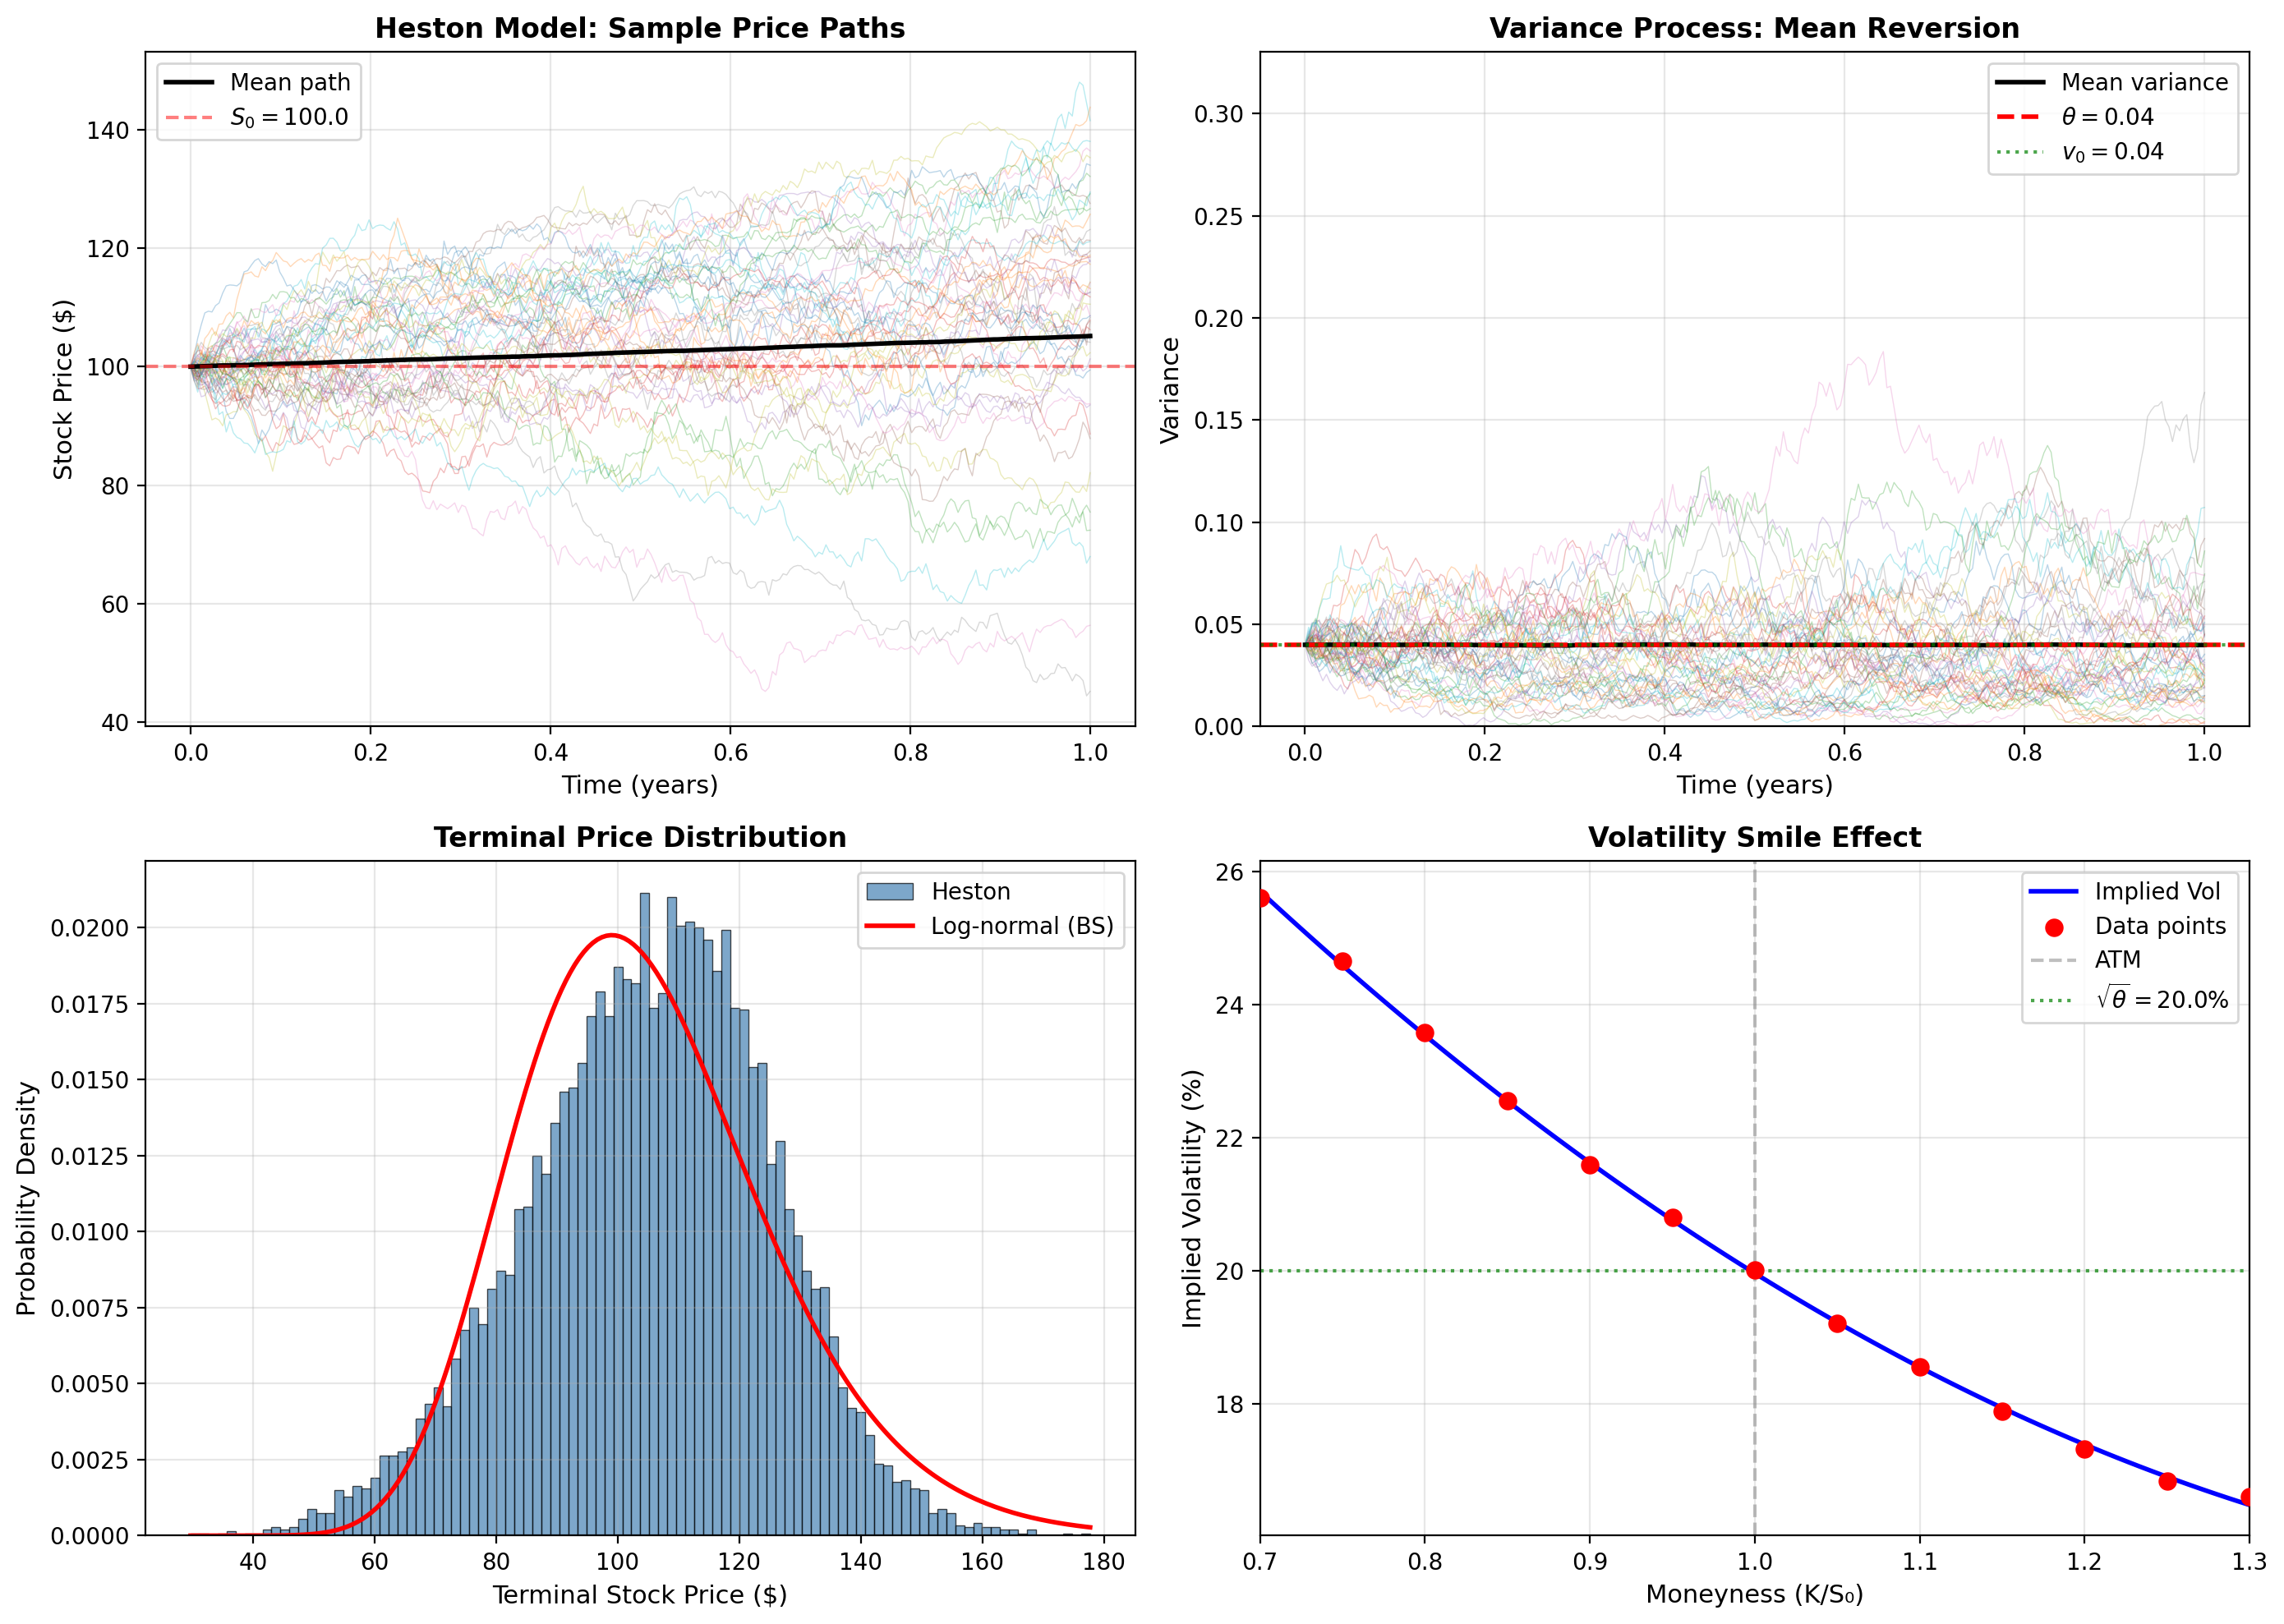

In [3]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Sample price paths
ax1 = axes[0, 0]
n_sample = 50
for i in range(n_sample):
    ax1.plot(t, S[i, :], alpha=0.3, linewidth=0.5)
ax1.plot(t, S.mean(axis=0), 'k-', linewidth=2, label='Mean path')
ax1.axhline(y=S0, color='r', linestyle='--', alpha=0.5, label=f'$S_0 = {S0}$')
ax1.set_xlabel('Time (years)', fontsize=11)
ax1.set_ylabel('Stock Price ($)', fontsize=11)
ax1.set_title('Heston Model: Sample Price Paths', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Variance paths showing mean reversion
ax2 = axes[0, 1]
for i in range(n_sample):
    ax2.plot(t, v[i, :], alpha=0.3, linewidth=0.5)
ax2.plot(t, v.mean(axis=0), 'k-', linewidth=2, label='Mean variance')
ax2.axhline(y=theta, color='r', linestyle='--', linewidth=2, label=f'$\\theta = {theta}$')
ax2.axhline(y=v0, color='g', linestyle=':', alpha=0.7, label=f'$v_0 = {v0}$')
ax2.set_xlabel('Time (years)', fontsize=11)
ax2.set_ylabel('Variance', fontsize=11)
ax2.set_title('Variance Process: Mean Reversion', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, max(0.15, v.max() * 1.1)])

# Plot 3: Terminal price distribution
ax3 = axes[1, 0]
terminal_prices = S[:, -1]
ax3.hist(terminal_prices, bins=100, density=True, alpha=0.7, 
         color='steelblue', edgecolor='black', linewidth=0.5, label='Heston')

# Compare with log-normal (Black-Scholes)
log_returns = np.log(terminal_prices / S0)
bs_mean = (mu - 0.5 * theta) * T
bs_std = np.sqrt(theta * T)
x_range = np.linspace(terminal_prices.min(), terminal_prices.max(), 200)
lognorm_pdf = stats.lognorm.pdf(x_range, s=bs_std, scale=S0 * np.exp(bs_mean))
ax3.plot(x_range, lognorm_pdf, 'r-', linewidth=2, label='Log-normal (BS)')

ax3.set_xlabel('Terminal Stock Price ($)', fontsize=11)
ax3.set_ylabel('Probability Density', fontsize=11)
ax3.set_title('Terminal Price Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Implied volatility smile (approximation)
ax4 = axes[1, 1]

# Calculate returns for different moneyness levels
log_returns = np.log(S[:, -1] / S0)
realized_vol = np.std(log_returns) / np.sqrt(T)

# Estimate volatility smile by computing realized vol for different strike bins
strike_range = np.linspace(0.7, 1.3, 13)  # Moneyness K/S0
impl_vols = []

for k in strike_range:
    K = k * S0
    # Paths that end near this strike
    mask = (S[:, -1] > K * 0.95) & (S[:, -1] < K * 1.05)
    if mask.sum() > 100:
        local_paths = S[mask, :]
        local_returns = np.diff(np.log(local_paths), axis=1)
        local_vol = np.std(local_returns) * np.sqrt(252)
        impl_vols.append(local_vol)
    else:
        impl_vols.append(np.nan)

# Fit a smooth curve
valid_idx = ~np.isnan(impl_vols)
strike_valid = strike_range[valid_idx]
vol_valid = np.array(impl_vols)[valid_idx]

if len(vol_valid) > 3:
    # Polynomial fit for smoothing
    coeffs = np.polyfit(strike_valid, vol_valid, 2)
    strike_smooth = np.linspace(0.7, 1.3, 100)
    vol_smooth = np.polyval(coeffs, strike_smooth)
    
    ax4.plot(strike_smooth, vol_smooth * 100, 'b-', linewidth=2, label='Implied Vol')
    ax4.scatter(strike_valid, vol_valid * 100, color='red', s=50, zorder=5, label='Data points')

ax4.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='ATM')
ax4.axhline(y=np.sqrt(theta) * 100, color='green', linestyle=':', 
            alpha=0.7, label=f'$\\sqrt{{\\theta}} = {np.sqrt(theta)*100:.1f}\\%$')
ax4.set_xlabel('Moneyness (K/S₀)', fontsize=11)
ax4.set_ylabel('Implied Volatility (%)', fontsize=11)
ax4.set_title('Volatility Smile Effect', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0.7, 1.3])

plt.tight_layout()

# Save the plot
plt.savefig('heston_stochastic_volatility_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
print("Plot saved to 'plot.png'")

plt.show()

## Statistical Analysis

We examine the statistical properties of the simulated paths to validate the model behavior.

In [4]:
# Statistical analysis of results
print("=" * 60)
print("HESTON MODEL SIMULATION RESULTS")
print("=" * 60)

# Price statistics
print("\n--- Terminal Price Statistics ---")
print(f"Mean:     ${S[:, -1].mean():.2f}")
print(f"Std Dev:  ${S[:, -1].std():.2f}")
print(f"Skewness: {stats.skew(S[:, -1]):.4f}")
print(f"Kurtosis: {stats.kurtosis(S[:, -1]):.4f}")
print(f"Min:      ${S[:, -1].min():.2f}")
print(f"Max:      ${S[:, -1].max():.2f}")

# Variance statistics
print("\n--- Terminal Variance Statistics ---")
print(f"Mean:     {v[:, -1].mean():.6f} (theoretical: {theta:.6f})")
print(f"Std Dev:  {v[:, -1].std():.6f}")
print(f"% Negative: {100 * (v[:, -1] < 0).mean():.2f}%")

# Log returns analysis
log_returns = np.log(S[:, -1] / S0)
print("\n--- Log Returns Statistics ---")
print(f"Mean:     {log_returns.mean():.4f} (theoretical: {(mu - 0.5*theta)*T:.4f})")
print(f"Std Dev:  {log_returns.std():.4f}")
print(f"Skewness: {stats.skew(log_returns):.4f} (negative indicates left skew)")
print(f"Kurtosis: {stats.kurtosis(log_returns):.4f} (excess > 0 indicates fat tails)")

# VaR and CVaR
confidence = 0.99
returns = (S[:, -1] - S0) / S0
VaR = np.percentile(returns, (1 - confidence) * 100)
CVaR = returns[returns <= VaR].mean()
print("\n--- Risk Metrics (99% confidence) ---")
print(f"Value at Risk (VaR):      {VaR*100:.2f}%")
print(f"Conditional VaR (CVaR):   {CVaR*100:.2f}%")

print("\n" + "=" * 60)

HESTON MODEL SIMULATION RESULTS

--- Terminal Price Statistics ---
Mean:     $105.16
Std Dev:  $19.97
Skewness: -0.2071
Kurtosis: -0.0228
Min:      $29.68
Max:      $177.72

--- Terminal Variance Statistics ---
Mean:     0.039877 (theoretical: 0.040000)
Std Dev:  0.029729
% Negative: 0.01%

--- Log Returns Statistics ---
Mean:     0.0306 (theoretical: 0.0300)
Std Dev:  0.2042
Skewness: -0.8691 (negative indicates left skew)
Kurtosis: 1.2717 (excess > 0 indicates fat tails)

--- Risk Metrics (99% confidence) ---
Value at Risk (VaR):      -43.97%
Conditional VaR (CVaR):   -49.80%



## Conclusions

The Heston stochastic volatility model successfully captures several key features observed in financial markets:

1. **Mean Reversion**: The variance process reverts to the long-term level $\theta$, as shown in the variance path plots.

2. **Leverage Effect**: The negative correlation $\rho = -0.7$ produces left-skewed returns, reflecting the empirical observation that volatility tends to increase when prices fall.

3. **Fat Tails**: The excess kurtosis indicates heavier tails than the normal distribution, better matching observed market returns.

4. **Volatility Smile**: The model generates an implied volatility smile, with higher implied volatility for out-of-the-money puts (low strikes) due to the negative correlation.

### Model Parameters Summary

| Parameter | Value | Interpretation |
|-----------|-------|----------------|
| $\kappa$ | 2.0 | Fast mean reversion (~6 months half-life) |
| $\theta$ | 0.04 | Long-term volatility of 20% |
| $\sigma$ | 0.3 | Moderate vol-of-vol |
| $\rho$ | -0.7 | Strong leverage effect |

### References

- Heston, S.L. (1993). "A Closed-Form Solution for Options with Stochastic Volatility with Applications to Bond and Currency Options." *The Review of Financial Studies*, 6(2), 327-343.
- Gatheral, J. (2006). *The Volatility Surface: A Practitioner's Guide*. Wiley Finance.